In [1]:
import numpy as np
from matplotlib import pyplot as plt

Creates a pulse with following equation $x(t) = A*T*\exp{(-(\frac{T}{t_{width}})^2 - \frac{T}{\tau})}$ where $T = t-t_{offset}$ to centre the pulse at some delay time (in this case 10 ps), $A$ is just a scaling factor, $\tau$ is a decay rate, $t_{width}$ is a factor that gives a width the pulse.

This is what is used for the simulation and is the reference as well. ie this a pulse that has been through the equivelent thickness of air already, as the simulations take this into account...

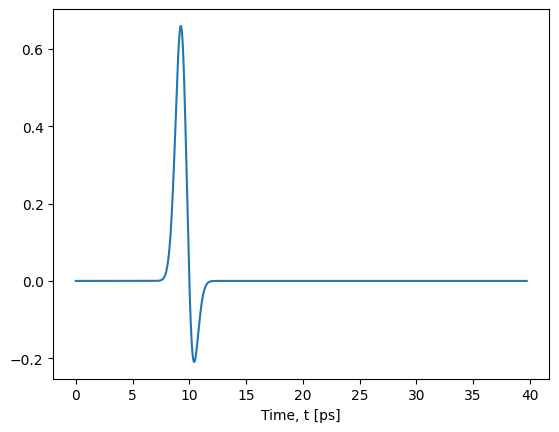

In [2]:
# Simulate Reference pulse
def simulate_reference(L, deltat):
    
    toff=1.0e-11
    twidth=8.0e-13
    tdecay=1.0e-12
    scale=1.0e12
    x=np.zeros(L, float)
    for t in range(0,L):
        T=t*deltat - toff
        x[t]=-scale*T* np.exp(-(T/twidth)**2 - T/tdecay)

    return x

# Create Ref pulse
deltat = 0.0194e-12
L = 2**11

x = simulate_reference(L, deltat)
t_axis = np.arange(0,L*deltat, deltat)


plt.plot(t_axis*1e12, x)
plt.xlabel('Time, t [ps]')
plt.show()

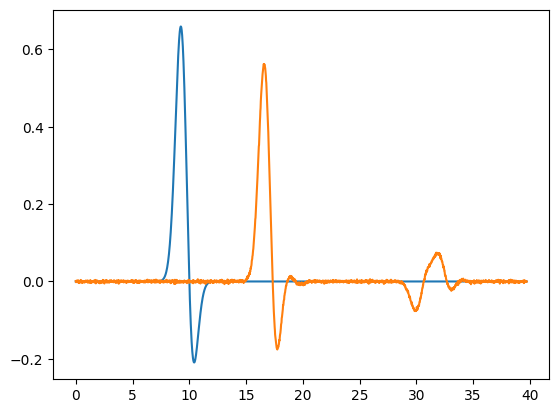

In [3]:
def rts(n0, nj, Dj):
    """
    Calculate reflection and transfer coeffs for individual layers.
    returns tuple of r, t and t**2 - r**2 for layer j.
    """

    c = np.cos(nj*Dj)
    s = np.sin(nj*Dj)
    d = c + (0.5j) * (nj/n0 + n0/nj) * s
    r = (0.5j) * s * (n0/nj - nj/n0) / d
    t = 1.0/d
    # note transmission coeff phase is relative to n0 and kD
    # s phase which is used to compute reflection coeff is relative to input
    return (r, t*np.exp((1J)*n0*Dj), t*t-r*r)


def RTm(m, n0, layers):
    """
    Apply rts across all layers.
    Reflection and Transmission coefficients for m layers.
    """
    U=0.0; V=1.0; T=1.0; R=0.0

    for j in range(0,m):
        nj = layers[j][0]
        Dj = layers[j][1]
        (r,t,s) = rts(n0, nj, Dj)
        Vlast = V
        (U,V) = (r*V + s*U, V - r*U)
        T = T * t * Vlast / V
        R = U/V

    return (R,T)


def simulate_parallel(x, layers, deltat, noise_level):
    L = len(x)
# convolution done with 4*L points
    M = 2 * L
    N = 4 * L
# wave number for frequency point k is k*dk
    deltaf = 1.0/(N*deltat)
    dk = 2 * np.pi * deltaf / 2.9979e8
    m = len(layers)
    indices = np.array([l[0] for l in layers])
    thicknesses = np.array([l[1] for l in layers])
    T = np.zeros(N, complex)

    for k in range(0,M+1):
        kD = k*dk*thicknesses
        nkD = np.array([(indices[l],kD[l]) for l in range(0,m)])

        T[k] = RTm(m, 1.0, nkD)[1]

    for k in range(1,M): T[N-k]=np.conjugate(T[k])

    z = np.zeros(N, float)
    z[0:L] = x[0:L]
    X = np.fft.fft(z)/N
    Y = T*X
    y = N * np.fft.ifft(Y).real + noise_level * np.random.randn(N)
    
    return (T,y)


#FIRST TERM n, SECOND TERM d.
layers = [(2.0, 1.0e-3), (3.0, 0.1e-3), (2.0, 1.0e-3)] 

(T,y) = simulate_parallel(x, layers, deltat, 0.002)

# truncate to L points
y = y[0:L]

plt.plot(t_axis*1e12,x,t_axis*1e12,y)
plt.show()

Here's an example of the simulation running muliple layers, n = 2,3,2 and d = 1,0.1,1 mm respectively


# Examples


## One slab n = 3.46 + 0.01i, d=3mm

alpha=1.0
alpha=0.8333333333333334
alpha=0.6666666666666667
alpha=0.5


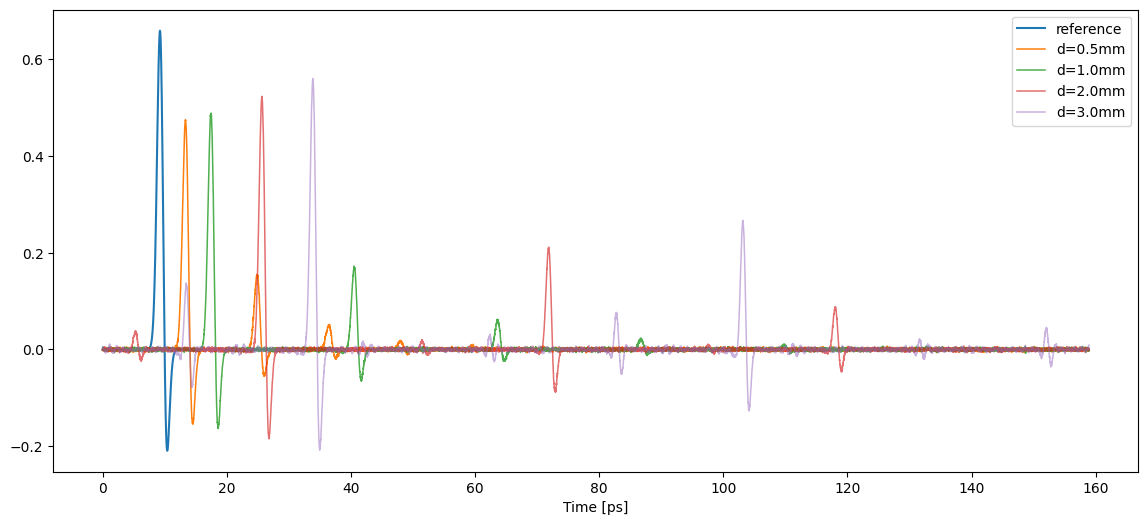

In [41]:
layer1 = [(3.46+0.01j, 3e-3)] #FIRST TERM n, SECOND TERM d.
layer2 = [(3.46+0.01j, 2e-3)]
layer3 = [(3.46+0.01j, 1e-3)]
layer4 = [(3.46+0.01j, 0.5e-3)]

layers = [layer4, layer3, layer2, layer1]
N = len(layers)
alpha_final = 0.5  # Desired final opacity

extended_time_range = np.arange(0, 4 * L * deltat, deltat)

plt.figure(figsize=(14,6))
plt.plot(t_axis * 1e12, x, label='reference')

for i, layer in enumerate(layers, start=1):
    alpha = 1 - ((i - 1) / (N - 1)) * (1 - alpha_final)
    (T, y) = simulate_parallel(x, layer, deltat, 0.002)
    plt.plot(extended_time_range * 1e12, y, label=f'd={layer[0][1] * 1000}mm', linewidth=1.1, alpha=alpha)
    print(f'alpha={alpha}')

plt.xlabel('Time [ps]')
plt.legend()
plt.show()

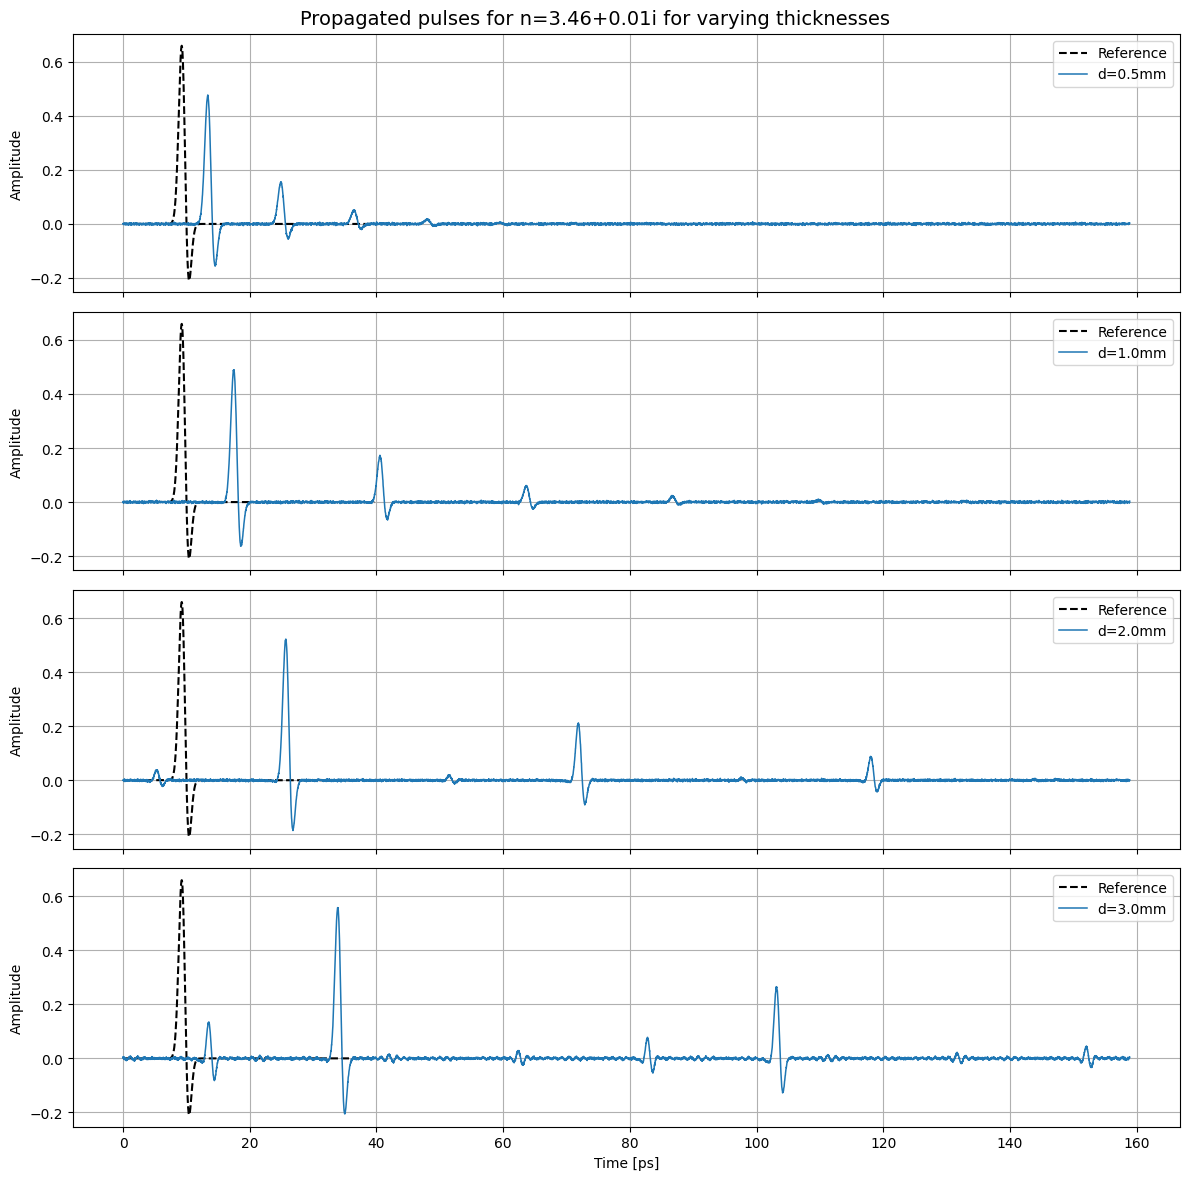

In [50]:
layers = [layer4, layer3, layer2, layer1]
N = len(layers)

fig, axes = plt.subplots(N, 1, figsize=(12, 3 * N), sharex=True)

for i, (layer, ax) in enumerate(zip(layers, axes), start=1):
    
    # Simulate the response
    (T, y) = simulate_parallel(x, layer, deltat, 0.002) 
    # Plot reference pulse
    ax.plot(t_axis * 1e12, x, label='Reference', linestyle='dashed', color='black')
    
    # Plot layer response
    ax.plot(extended_time_range * 1e12, y, label=f'd={layer[0][1] * 1000}mm', linewidth=1.1)
    
    # Customize subplot
    ax.set_ylabel('Amplitude')
    ax.legend()
    ax.grid(True)

# Common labels
axes[-1].set_xlabel('Time [ps]')

# Adjust suptitle
plt.suptitle('Propagated pulses for n=3.46+0.01i for varying thicknesses', fontsize=14)
plt.subplots_adjust(top=0.92)  # Adjust top margin to prevent overlap

plt.tight_layout()
plt.show()

## One slab, n = 2.5, d = 0.4 mm

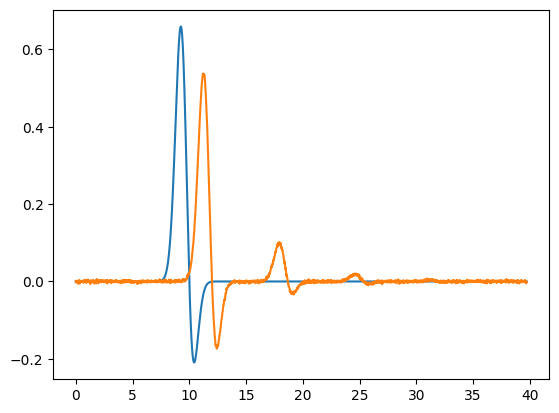

In [11]:

layers=[(2.5, 0.4e-3)] #FIRST TERM n, SECOND TERM d.
#layers=[(1.0, 100.0e-3)]
(T,y)=simulate_parallel(x, layers, deltat, 0.002)
# truncate to L points
y=y[0:L]

plt.plot(t_axis*1e12,x,t_axis*1e12,y)
plt.show()

## One slab, n = 4, d = 0.2 mm

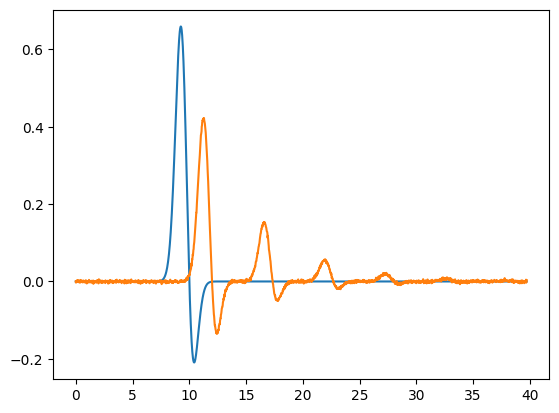

In [5]:
layers=[(4, 0.2e-3)] #FIRST TERM n, SECOND TERM d.
#layers=[(1.0, 100.0e-3)]
(T,y)=simulate_parallel(x, layers, deltat, 0.002)
# truncate to L points
y=y[0:L]

plt.plot(t_axis*10**12,x,t_axis*10**12,y)
plt.show()

## Three layers, n = [2.2, 2.5 - 0.05i, 2.2], d = [0.2, 0.1, 0.2] mm

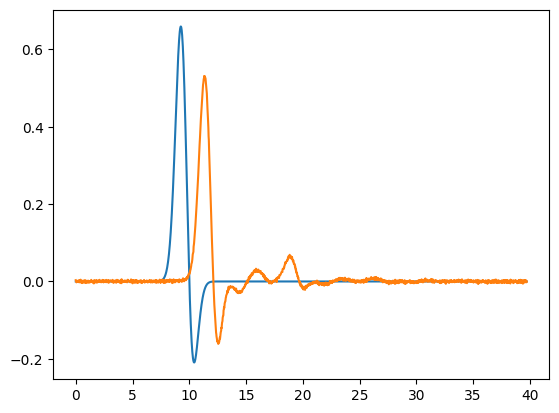

In [6]:
layers=[(2.2, 0.2e-3),(2.5 - 0.1j, 0.1e-3),(2.2, 0.2e-3)] #FIRST TERM n, SECOND TERM d.
#layers=[(1.0, 100.0e-3)]
(T,y)=simulate_parallel(x, layers, deltat, 0.002)
# truncate to L points
y=y[0:L]

plt.plot(t_axis*1e12,x,t_axis*1e12,y)
plt.show()